#Import the required libraries

We will start by importing the libraries necessary to our project:

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

Load Data

Dataset: https://www.kaggle.com/samuelmcguire/wine-reviews-data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
meta = pd.read_csv("/content/drive/Othercomputers/Mi PC/02. Programacion/Proyectos/Predicción puntos vino/wine.csv")

meta.head()

,wine,winery,category,designation,varietal,appellation,alcohol,price,rating,reviewer,review
0,J. Lohr 2000 Hilltop Vineyard Cabernet Sauvignon (Paso Robles),J. Lohr,Red,Hilltop Vineyard,Cabernet Sauvignon,"Paso Robles, Central Coast, California, US",NaN,$32,87,NaN,"Held back nearly five years, this Cab still has some sturdy tannins, but I would drink it now because the fruit's in a precarious position. It's rich and tasty now in black currants and cherries, but too soft to age."
1,Antucura 2010 Pinot Noir (Vista Flores),Antucura,Red,NaN,Pinot Noir,"Vista Flores, Mendoza Province, Argentina",15%,$17,85,Michael Schachner,"Rubbery, bold and earthy on the nose, then full and sticky in the mouth, with sweet black fruit flavors. Tastes more like a Bordeaux red wine than textbook Pinot Noir courtesy of heavy extraction, darkness and oak. Tastes good but could use a lesson in elegance and restraint."
2,Quinta do Portal 1999 Quinta do Portal Reserva Red (Douro),Quinta do Portal,Red,Quinta do Portal Reserva,"Red Blends, Red Blends","Douro, Portugal",NaN,NaN,90,Roger Voss,"Smoky, meaty aromas lead into perfumed fruit flavors. The tannins are soft but dry; the fruit is very aromatic with a touch of violets and some rich, dark tannins underneath. The wine will age well—probably 5–10 years. —R.V."
3,Tenuta di Ghizzano 2006 Il Ghizzano Red (Toscana),Tenuta di Ghizzano,Red,Il Ghizzano,"Red Blends, Red Blends","Toscana, Tuscany, Italy",13.5%,$18,86,NaN,"The nose is rather neutral save for distant aromas of cherry fruit, boysenberry and spice. However, the mouthfeel is more interesting thanks to the wine's chewy succulence and fresh, zesty close: An 80-20 blend of Sangiovese and Merlot."
4,Tenuta San Francesco 2007 Tramonti White (Campania),Tenuta San Francesco,White,Tramonti,White Blend,"Campania, Southern Italy, Italy",13.5%,$21,85,NaN,"This intriguing blend of Falanghina, Biancolella and Pepella (three relatively unknown indigenous grapes) has a candy- or soda-like quality that recalls butterscotch and caramel. However, those notes are balanced by an elegant mineral tone and the wine has good dimension on the close."


#Data Exploration and Pre-processing

In [4]:
meta.shape

(323237, 11)

In [5]:
meta.drop(['wine', 'winery', 'category', 'designation', 'varietal', 'appellation', 'alcohol', 'price', 'reviewer'], axis=1, inplace=True)

In [6]:
# Cleaning: remove samples with NaN
meta.isnull().sum()

rating       0
review    1129
dtype: int64

In [7]:
data_cleaned = meta.dropna()

In [8]:
data_cleaned.isnull().sum()

rating    0
review    0
dtype: int64

In [9]:
# how many movie genres have been covered in this dataset?
len(set(data_cleaned['rating']))

21

In [10]:
points = data_cleaned['rating'].tolist()

In [11]:
points = nltk.FreqDist(points) 

# create dataframe
all_points = pd.DataFrame({'rating': list(points.keys()), 
                              'Count': list(points.values())})

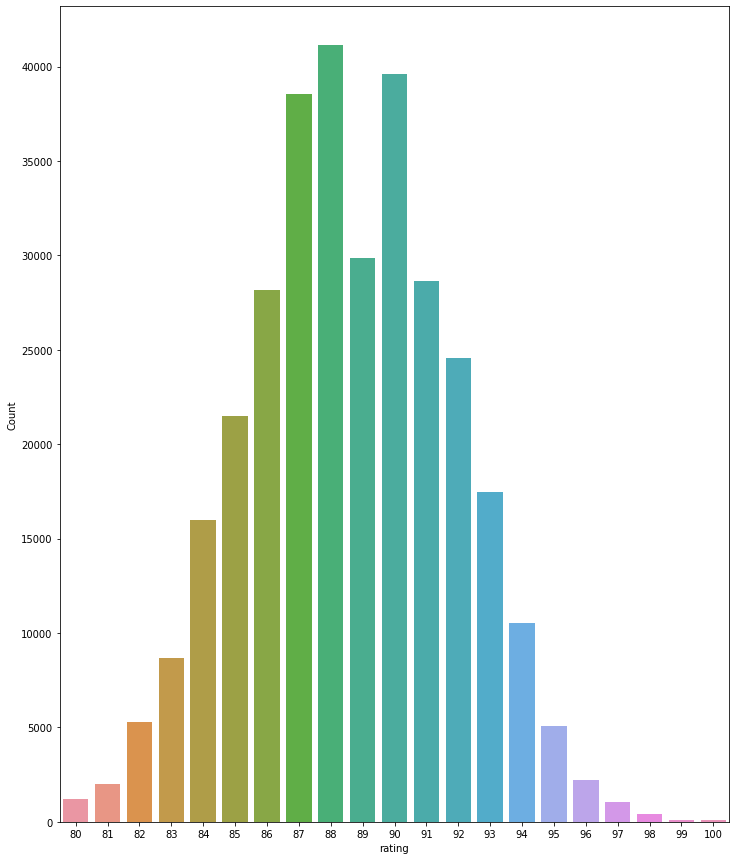

In [12]:
g = all_points.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, y = "Count", x = "rating") 
ax.set(ylabel = 'Count') 
plt.show()

In [13]:
#Text cleaning

def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [14]:
data_cleaned['clean_review'] = data_cleaned['review'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


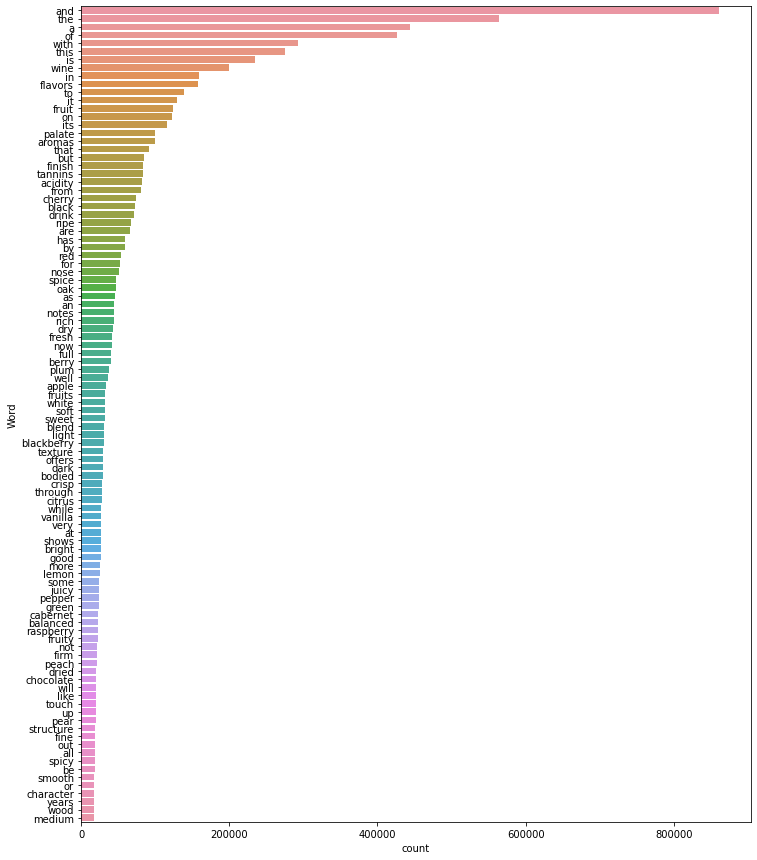

In [15]:
#cleaning stop words

def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(data_cleaned['clean_review'], 100)

In [16]:
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

data_cleaned['clean_review'] = data_cleaned['clean_review'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


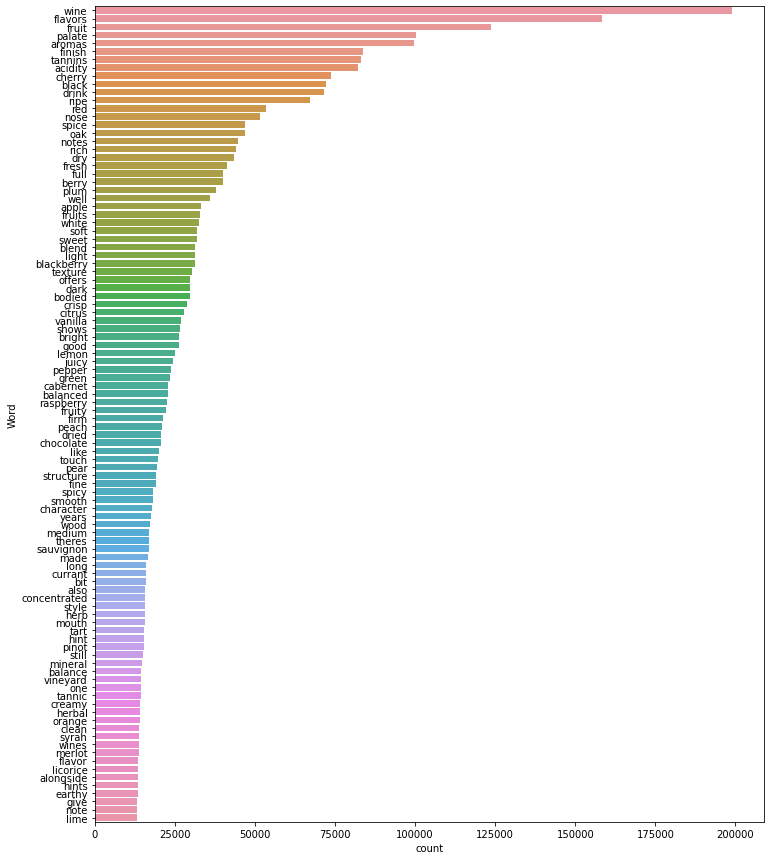

In [17]:
#Check

freq_words(data_cleaned['clean_review'], 100)

#Converting Text to Features

In [33]:
data_cleaned['rating']=data_cleaned['rating'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_cleaned['rating'])

# transform target variable
y = multilabel_binarizer.transform(data_cleaned['rating'])

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000) #10,000 most frequent words

In [52]:
#split our data into train and validation sets for training and evaluating

xtrain, xval, ytrain, yval = train_test_split(data_cleaned['clean_review'], y, test_size=0.5, random_state=9)

In [53]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

#Building Movie Genre Prediction Model

Training 363 models can take a considerable amount of time on a modest system. Hence, I will build a Logistic Regression model as it is quick to train on limited computational power:

In [54]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

In [55]:
# We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [56]:
# Finally, fit the model on the train set:

clf.fit(xtrain_tfidf, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


OneVsRestClassifier(estimator=LogisticRegression())

In [57]:
# make predictions for validation set

y_pred = clf.predict(xval_tfidf)

In [58]:
# Let’s check out a sample from these predictions:

y_pred[3] #array of 363 genres

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

It is a binary one-dimensional array of length 363. Basically, it is the one-hot encoded form of the unique genre tags. We will have to find a way to convert it into movie genre tags.

Luckily, sk-learn comes to our rescue once again. We will use the inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags:

In [59]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('8',)

In [60]:
# To evaluate our model’s overall performance

f1_score(yval, y_pred, average="micro")

0.6255588866873449

In [61]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)
t = 0.4 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [62]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")

0.6341583913838249

#Take a movie plot text and follow the below steps

In [63]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

In [64]:
q_new = input("Enter the review: ")

print(infer_tags(q_new))

Enter the review: Tasting this wine blind confirmed precisely my impression from tasting a press sample in late December of 2021, right down to the exact score.  The current release of this is probably the best I’ve ever tasted over three decades of admiration for the Blanc de Blancs from Delamotte.  Made with Chardonnay sourced from the famed Grand Cru villages of Le Mesnil-sur-Oger, Oger, and Cramant, it is crafted in a straightforward manner to display the fruit from these great chalky limestone terroirs, with low dosage and only 10% reserve wines added to the base vintage.  Both of these last two facts would seem to presage an austere wine, but that’s emphatically not the case here, thanks to long aging on the lees prior to disgorgement and then additional aging under cork.  The aromas are delicate but very complex, with yeasty notes perfectly balanced against suggestions of ripe fruit, and the flavors are at once very fresh but also quite generous, with creamy texture enlivened by